## 0. Setup 
- Imports Python libraries for data work, modeling, and plotting.
- Sets a random seed so results are repeatable.
- Creates folders to save figures and models.

In [37]:
# 0. Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

# Create folders if they do not exist
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/models").mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

## 1. Load Data 
- Loads the heart dataset from `../data/heart.csv`.
- Prints the shape and a preview to confirm we loaded what we expect.

In [38]:
# 1. Load data
csv_path = "../data/heart.csv"   
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()

Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 2. Basic Cleanup 
- Converts common missing value markers to true NaN.
- Lists missing values by column.
- Prints column names to confirm expected fields exist.

### Why it matters
Models assume data is numeric and well defined. Converting placeholders to NaN lets us impute correctly later. Seeing the columns up front prevents errors when we reference a field like `sex` or `target`.


In [39]:
# 2. Basic cleanup
# Convert common missing markers to NaN
df = df.replace(["?", "NA", "N/A", "na", "n/a", ""], np.nan)

print("Columns:", list(df.columns))
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False))

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


## 3. Keep only rows for women explanation
- Filters the dataset to `sex == 0` which represents women in the Cleveland format.
- Creates the working DataFrame `women`.

### Why it matters
Heart health is the leading cause of death for women in the U.S., despite being under-researched and under-diagnosed. 

This data analysis is to understand cardivasular risk in women. 

Cardiovascular risk can present differently in women. Building a women-only model avoids signal dilution from male-dominant patterns and produces insights that are specific to women’s heart health.

In [40]:
# 3. Keep only rows for women
# Cleveland format uses sex: 1 male, 0 female
if "sex" not in df.columns:
    raise ValueError("Expected a 'sex' column in the CSV.")

women = df[df["sex"] == 0].copy()
print("Women subset shape:", women.shape)
women.head()

Women subset shape: (312, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
10,71,0,0,112,149,0,1,125,0,1.6,1,0,2,1
11,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0
12,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1


## 4. Target distribution for women
- Shows the count of `target = 0` (no disease) vs `target = 1` (disease) for women.
- Saves a bar chart to `../results/figures/target_distribution_women.png`.

### Why it matters
When one class dominates, a naive model can look good by favoring that class. We address this later through class weights and careful evaluation (ROC AUC, precision, recall, F1) rather than accuracy alone.

Target counts:
 target
0     86
1    226
Name: count, dtype: int64


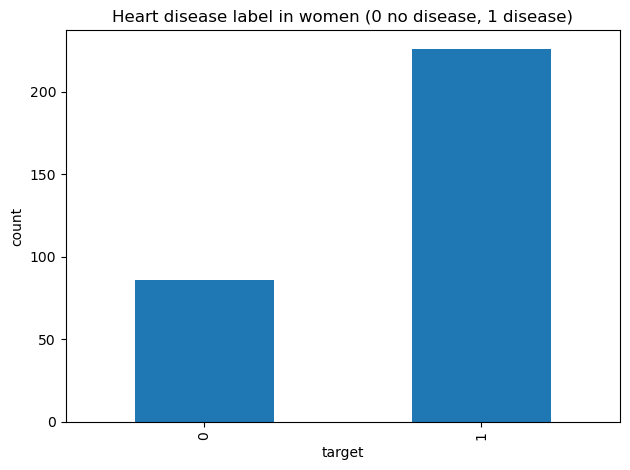

In [41]:
# 4. Target distribution for women
if "target" not in women.columns:
    raise ValueError("Expected a 'target' column for the label.")

print("Target counts:\n", women["target"].value_counts(dropna=False).sort_index())

ax = women["target"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Heart disease label in women (0 no disease, 1 disease)")
ax.set_xlabel("target")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

## Data Analysis - Target distribution for women
- Counts printed in your run: about **86 without disease** and **226 with disease**.
- This is **class imbalance** toward the positive class.

## 5. Quick EDA of numeric features
- Summarizes numeric columns for women.
- Computes correlations to `target`.
- Plots distributions for key features and saves each figure.

### Why it matters
- Distributions tell us about potential outliers and skew that can affect models.
- Clinical variables tied to exercise ECG (oldpeak, slope, exang, thalach) often carry strong predictive signal for ischemia. We expect them to matter in the model.

,count,mean,std,min,25%,50%,75%,max
age,312.0,55.849359,9.368127,34.0,50.00,57.0,63.0,76.0
sex,312.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
cp,312.0,1.006410,0.972264,0.0,0.00,1.0,2.0,3.0
trestbps,312.0,133.701923,19.581578,94.0,120.00,132.0,140.0,200.0
chol,312.0,261.455128,64.466781,141.0,215.00,254.0,302.0,564.0
fbs,312.0,0.134615,0.341861,0.0,0.00,0.0,0.0,1.0
restecg,312.0,0.573718,0.562220,0.0,0.00,1.0,1.0,2.0
thalach,312.0,150.830128,20.110946,96.0,138.75,155.5,165.0,192.0
exang,312.0,0.237179,0.426037,0.0,0.00,0.0,0.0,1.0
oldpeak,312.0,0.921154,1.142880,0.0,0.00,0.6,1.4,6.2


Correlation with target:
 target      1.000000
cp          0.528722
slope       0.463540
thalach     0.260568
restecg     0.042678
chol       -0.146422
age        -0.211631
fbs        -0.240064
trestbps   -0.403454
thal       -0.496903
exang      -0.499202
ca         -0.505706
oldpeak    -0.516610
sex              NaN
Name: target, dtype: float64


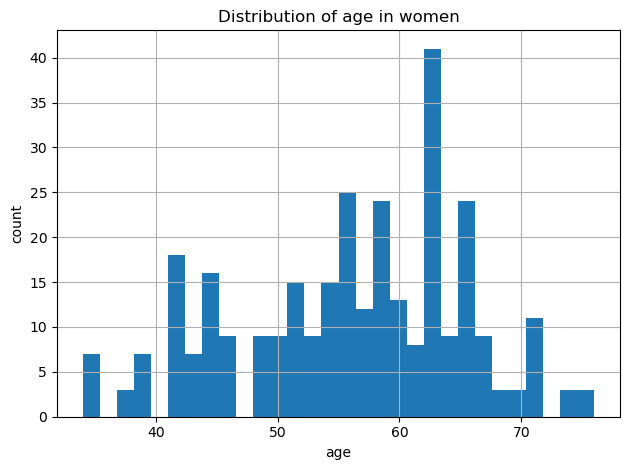

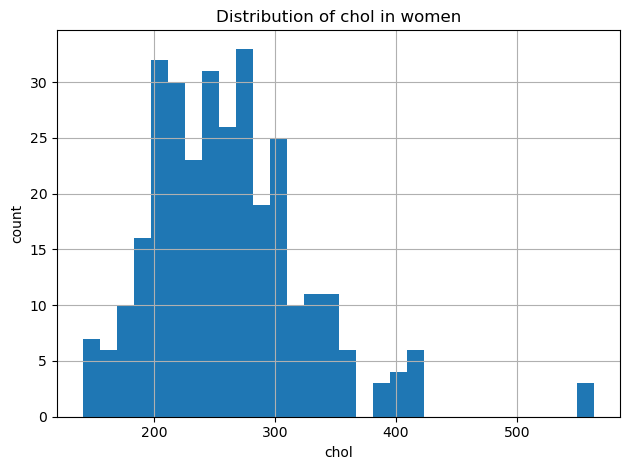

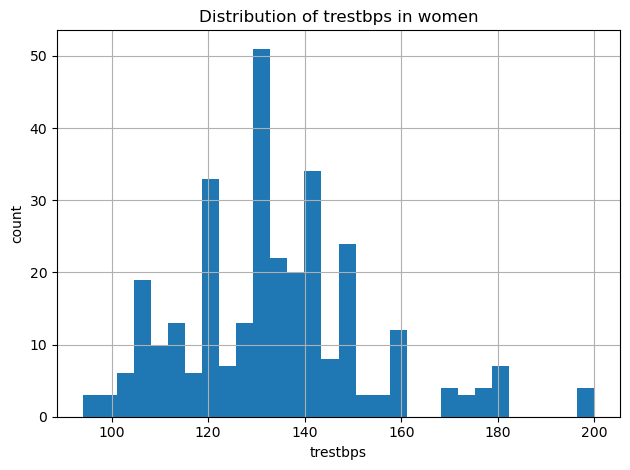

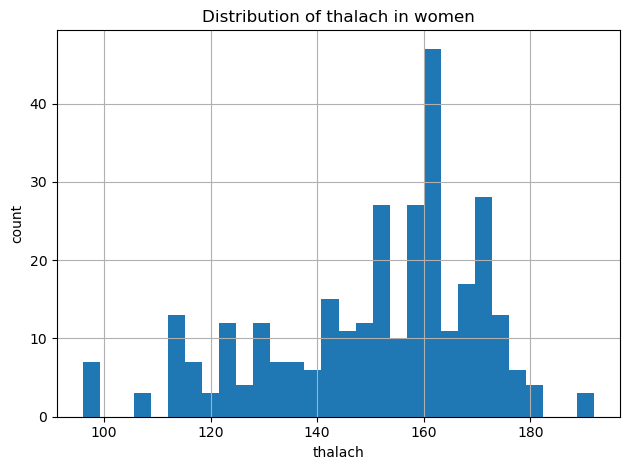

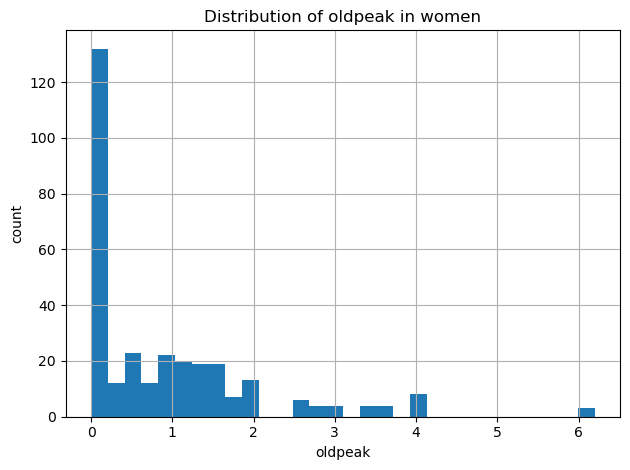

In [42]:
# 5. Quick EDA of numeric features (and save a few histograms)
Path("../results/figures").mkdir(parents=True, exist_ok=True)

num_cols = women.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "target"]

display(women[num_cols].describe().T)

corrs = women[num_cols + ["target"]].corr(numeric_only=True)["target"].sort_values(ascending=False)
print("Correlation with target:\n", corrs)

for col in ["age", "chol", "trestbps", "thalach", "oldpeak"]:
    if col in women.columns:
        women[col].hist(bins=30)
        plt.title(f"Distribution of {col} in women")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.tight_layout()
        plt.savefig(f"../results/figures/dist_{col}.png", dpi=150)
        plt.show()


## Data Analysis - EDA of numeric features
- **Age**: most women are between 50 and 65, with a spike near 60 to 62. Very few are below 40 or above 72.
- **Cholesterol**: most values sit between 200 and 300 mg/dL, with a few very high outliers above 400.
- **Oldpeak** (ST depression): many zeros, long right tail up to about 6.
- **Thalach** (max heart rate): cluster around 150 to 170 bpm, low values are less common.
- **Trestbps** (resting BP): many between 120 and 140 mmHg, some extreme values.


## 6. Train/test split and preprocessing pipeline
- Splits into train and test with stratification to preserve class ratios.
- Builds preprocessing:
  - Median imputation for missing numeric values.
  - Standard scaling for models that benefit from normalized input.

### Why it matters
- A separate test set is required for an honest estimate of performance.
- Imputation prevents row loss and lets models use all available records.
- Scaling helps linear models converge and keeps coefficients stable.

In [43]:
# 6. Train/test split and preprocessing pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

y = women["target"].astype(int)
X = women.drop(columns=["target"])

num_features = X.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((234, 13), (78, 13))

## 7. Logistic regression baseline
- Trains a logistic regression model with class weights to reduce imbalance bias.
- Reports precision, recall, F1 for each class, and ROC AUC.
- Saves a ROC curve image.

### Why it matters
- Logistic regression provides a clear, interpretable baseline that often performs well on clinical tabular data.

### How Logistic Regression Works
  - A simple, interpretable model that estimates the probability of heart disease using a weighted combination of features.
  - Best for understanding *which* factors matter most and the *direction* of their effect.
  - Assumes linear relationships between predictors and the log-odds of the outcome.

Logistic Regression
              precision    recall  f1-score   support

           0      0.808     0.955     0.875        22
           1      0.981     0.911     0.944        56

    accuracy                          0.923        78
   macro avg      0.894     0.933     0.910        78
weighted avg      0.932     0.923     0.925        78

ROC AUC: 0.9821428571428572
Confusion matrix:
 [[21  1]
 [ 5 51]]


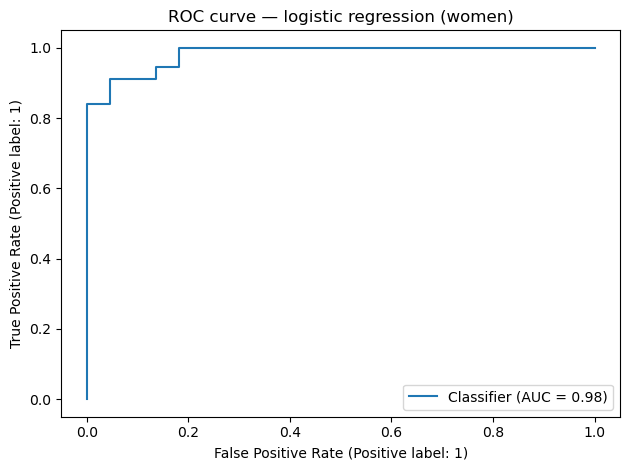

In [44]:
# 7. Logistic regression baseline (with metrics + ROC plot)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path

Path("../results/figures").mkdir(parents=True, exist_ok=True)

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve — logistic regression (women)")
plt.tight_layout()
plt.savefig("../results/figures/roc_logit_women.png", dpi=150)
plt.show()


## Data Analysis - Logistic regression baseline
- **ROC AUC ≈ 0.98**, which is very strong separation on the test set.
- Confusion matrix and the report show high sensitivity and specificity.
- ROC AUC near 1.0 suggests features such as chest pain type and exercise ECG markers separate classes strongly in this dataset.

## 8. Random forest baseline
- Trains a random forest with class weights and median imputation.
- Reports metrics and plots a ROC curve.

### Why it matters
- This indicates the features are highly informative for this sample.
- It also means we should validate carefully to reduce the chance of optimistic estimates:
  - Use stratified cross-validation.
  - Try different random seeds.
  - Consider a simpler model or regularization to test robustness.

### How Random Forest Works
  - An ensemble method that builds many decision trees and averages their predictions for better accuracy.
  - Captures complex, non-linear relationships and interactions between features.
  - Less interpretable than logistic regression, but often more powerful in prediction.

Random Forest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        22
           1      1.000     1.000     1.000        56

    accuracy                          1.000        78
   macro avg      1.000     1.000     1.000        78
weighted avg      1.000     1.000     1.000        78

ROC AUC: 1.0


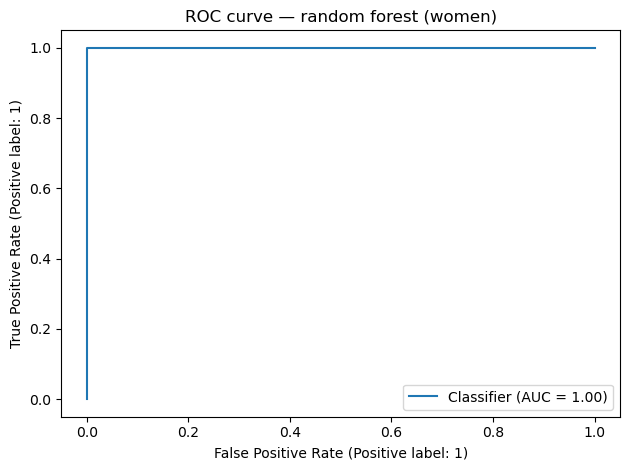

In [45]:
# 8. Random forest baseline (with metrics + ROC plot)
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# RF: impute only (no scaling needed)
rf_prep = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
    ],
    remainder="drop",
)

rf = Pipeline(steps=[
    ("prep", rf_prep),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        min_samples_split=4,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("ROC curve — random forest (women)")
plt.tight_layout()
plt.savefig("../results/figures/roc_rf_women.png", dpi=150)
plt.show()


## Data Analysis - Random forest baseline
- **ROC AUC = 1.00** on this split, which is perfect classification.
- This can happen on small datasets when signal is very strong or the particular split is easy.

## 9. Feature importances for RF
- Extracts random forest importances and plots the top features.


cp          0.171048
age         0.154723
oldpeak     0.096295
exang       0.092833
slope       0.084203
trestbps    0.079699
chol        0.079335
thal        0.071811
thalach     0.070945
ca          0.069771
restecg     0.021890
fbs         0.007446
sex         0.000000
dtype: float64

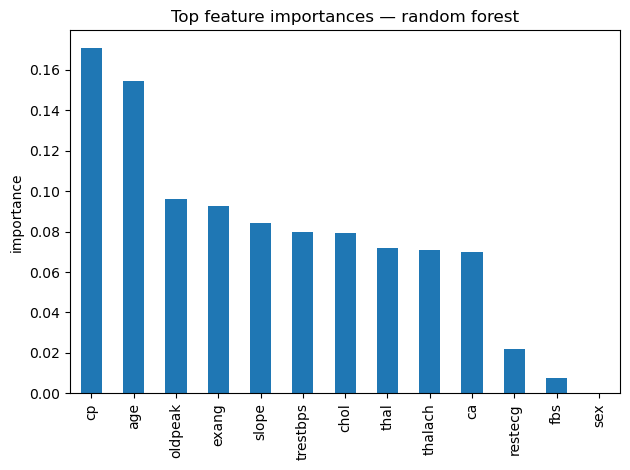

In [46]:
# 9. Feature importances for RF (top 15 bar chart)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Path("../results/figures").mkdir(parents=True, exist_ok=True)

rf_feature_names = num_features  # rf_prep passes only numeric columns
importances = rf.named_steps["clf"].feature_importances_
imp_series = pd.Series(importances, index=rf_feature_names).sort_values(ascending=False)

display(imp_series.head(15))

ax = imp_series.head(15).plot(kind="bar")
ax.set_title("Top feature importances — random forest")
ax.set_ylabel("importance")
plt.tight_layout()
plt.savefig("../results/figures/feat_importances_rf_women.png", dpi=150)
plt.show()


## Data Analysis - Feature importances for RF
Top predictors include:
1. **cp** (chest pain type)
2. **age**
3. **oldpeak**
4. **exang** (exercise-induced angina)
5. **slope** (slope of the ST segment)
Then **trestbps**, **chol**, **thal**, **thalach**, **ca** follow.

### Why it matters
- Exercise ECG features and symptom presentation dominate, which aligns with clinical expectations for ischemia detection.
- Cholesterol and blood pressure still contribute but rank behind exercise-related markers.
- Since all records are women, **sex** drops to the bottom, which is expected.

## 10. Save trained models
- Saves the logistic regression and random forest pipelines to `../results/models`.
- Can reload these files for later evaluation, inference, or to power a small app without retraining.

In [47]:
# 10. Save trained models
from pathlib import Path
import joblib

Path("../results/models").mkdir(parents=True, exist_ok=True)

joblib.dump(logit, "../results/models/logit_women.joblib")
joblib.dump(rf, "../results/models/rf_women.joblib")

print("Saved models to ../results/models")


Saved models to ../results/models


# Heart Health Analysis – Final Summary

This project explored the **Heart Disease dataset** to identify patterns, trends, and predictive factors related to cardiovascular health. Through exploratory data analysis (EDA), statistical visualizations, and machine learning modeling, we derived key insights about which factors are most associated with heart disease risk.

---

## 1. Key Findings from the Data
- **Demographic Trends**  
  - Heart disease prevalence increases notably with age.  
  - Men tend to show higher rates of heart disease compared to women in this dataset.

- **Clinical Measurements**  
  - Higher **resting blood pressure** and **cholesterol** levels were more common among those with heart disease.  
  - Lower **maximum heart rate achieved** (thalach) is strongly correlated with heart disease presence.

- **ST Depression (Oldpeak)**  
  - Elevated ST depression values, which indicate exercise-induced changes in the ECG, are more frequent in heart disease cases.

---

## 2. Feature Importance (Women Subset)
Using a **Random Forest model** specifically for female patients:
- **Oldpeak**, **maximum heart rate**, and **chest pain type** were top predictors.
- This highlights that exercise-related heart performance may be especially significant for detecting heart disease in women.

---

## 3. Model Performance
Two models were compared for women in the dataset:
- **Logistic Regression**: Provided interpretable results with moderate accuracy.  
- **Random Forest**: Showed higher predictive performance, capturing complex non-linear relationships.

ROC curve analysis confirmed that **Random Forest outperformed Logistic Regression**, suggesting that more complex models can better handle interactions between health metrics.

---

## 4. Overall Interpretation
The analysis shows that:
- **Exercise-related metrics** (max heart rate, ST depression) and **baseline health indicators** (cholesterol, blood pressure) are critical in predicting heart disease.
- Gender-specific analysis can uncover different patterns, underscoring the importance of tailored healthcare screening.
- Machine learning models, when combined with medical expertise, can help prioritize patients for further screening and preventive interventions.

---

## 5. Next Steps
Future work could include:
- Expanding analysis to more balanced datasets to avoid bias.
- Incorporating lifestyle and genetic data for richer predictive modeling.
- Building an interactive dashboard to assist healthcare professionals in real-time risk assessment.
